In [2]:

import tensorflow as tf


# Now, the model will run on CPU


# Check GPU availability
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)


In [3]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import seaborn as sns
import tensorflow as tf
from keras.utils import plot_model
from imblearn.over_sampling import SMOTE
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, Dense, Reshape, Dropout, Multiply, Flatten, GlobalAveragePooling2D, Input, MaxPooling2D
from keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score
from tensorflow.keras.applications import ResNet50V2, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img,img_to_array
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, matthews_corrcoef, precision_score, recall_score, f1_score
from PIL import Image
from tensorflow.keras.applications import ResNet50

In [4]:
folder = r'/home/kevin/Breast Cancer Detection - Minor Project/augmented' # Update with your data folder path
  # ResNet-50 input size
folder_path = pathlib.Path(folder)

In [5]:
IMG_HEIGHT, IMG_WIDTH = 224, 224
IMG_SIZE = 224

In [6]:
def adjust_contrast(image):
    # Adjust contrast by a factor. You can change the factor as needed.
    return tf.image.adjust_contrast(image, contrast_factor=1.4)


train_generator = ImageDataGenerator(
        zoom_range=[0.99, 1.01],  # set range for random zoom
        brightness_range=[0.9, 1.01],
        rotation_range=90,
        shear_range=1.2,
        data_format="channels_last",
        fill_mode="reflect",
        channel_shift_range=50,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,
        preprocessing_function= adjust_contrast # randomly flip images
    )

In [7]:
# Data preprocessing

train_data_gen = train_generator.flow_from_directory(directory=folder, target_size=(IMG_SIZE, IMG_SIZE), batch_size=3000, shuffle=False)
train_data, train_labels = next(train_data_gen)

Found 7909 images belonging to 2 classes.


In [8]:
# Print the number of images before SMOTE
print(f"Number of images before SMOTE: {train_data_gen.n}")

Number of images before SMOTE: 7909


In [9]:
# Synthetic Minority Over-sampling Technique
sm = SMOTE(sampling_strategy='auto',random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)
train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
train_labels = train_labels.reshape(-1, 1)


In [10]:
print("Shape of train_data before SMOTE:", train_data.shape)

Shape of train_data before SMOTE: (4960, 224, 224, 3)


In [11]:
print("Shape of train_data:", train_data.shape)
print("Shape of train_labels:", train_labels.shape)

Shape of train_data: (4960, 224, 224, 3)
Shape of train_labels: (4960, 1)


In [12]:

# Train-test split
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

In [13]:
print("Shape of train_data:", train_data.shape)
print("Shape of train_labels:", train_labels.shape)

Shape of train_data: (3174, 224, 224, 3)
Shape of train_labels: (3174, 1)


In [14]:
# Squeeze-and-Excitation Block
def se_block(input_tensor, ratio=16):
    """ Create a squeeze and excitation block
    Args:
        input_tensor: input Keras tensor
        ratio: reduction ratio to calculate the bottleneck for channel recalibration
    Returns: a Keras tensor after applying squeeze and excitation block
    """
    channel_axis = -1  # Channels last format
    filters = input_tensor.shape[channel_axis]  # Number of channels

    se_shape = (1, 1, filters)

    # Squeeze operation: Global Average Pooling
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape(se_shape)(se)
    
    # Excitation operation: Fully connected layers
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    
    # Scale: Multiply the original input with the recalibrated scale
    x = Multiply()([input_tensor, se])
    return x

In [15]:
# Load the pre-trained ResNet50 model without the top fully connected layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))



# Add Squeeze-and-Excitation blocks to each residual block of ResNet50 if desired
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):  # Add SE block after each Conv2D layer
        x = se_block(layer.output)

# Custom layers after base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze more layers
for layer in base_model.layers[:-30]:  # unfreeze the last 30 layers
    layer.trainable = True

# Summary of the model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,686,913 (97.99 MB)

 Trainable params: 11,183,617 (42.66 MB)

 Non-trainable params: 14,503,296 (55.33 MB)

In [16]:
from tensorflow.keras.callbacks import LearningRateScheduler

In [17]:
# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('model_checkpoint_run2.keras', save_best_only=True, save_weights_only=False, monitor='val_loss', mode='min', verbose=1)




In [30]:
# Define the early stopping callback
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # You can also use 'val_accuracy' or other metrics
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Prints a message when early stopping is triggered
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [31]:
history = model.fit(
    train_data, 
    train_labels, 
    epochs=10,  # Increased epochs
    batch_size=16, 
    validation_data=(val_data, val_labels),
    callbacks=[early_stopping, checkpoint]  # Add both callbacks here
)

Epoch 1/10


2024-10-04 05:53:53.186668: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1911103488 exceeds 10% of free system memory.


199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9953 - loss: 0.0146
Epoch 1: val_loss improved from inf to 0.07785, saving model to model_checkpoint_run2.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 743s 4s/step - accuracy: 0.9953 - loss: 0.0146 - val_accuracy: 0.9786 - val_loss: 0.0779
Epoch 2/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9972 - loss: 0.0103
Epoch 2: val_loss did not improve from 0.07785
199/199 ━━━━━━━━━━━━━━━━━━━━ 705s 4s/step - accuracy: 0.9972 - loss: 0.0103 - val_accuracy: 0.9332 - val_loss: 0.2338
Epoch 3/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9938 - loss: 0.0160
Epoch 3: val_loss did not improve from 0.07785
199/199 ━━━━━━━━━━━━━━━━━━━━ 696s 3s/step - accuracy: 0.9938 - loss: 0.0161 - val_accuracy: 0.9433 - val_loss: 0.1839
Epoch 4/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9932 - loss: 0.0241
Epoch 4: val_loss did not improve from 0.07785
199/199 ━━━━━━━━━━━━━━━━━━━━ 696s 3s/step - accuracy: 0.9932 - loss: 0.0241 - val_ac

In [21]:
model.save('SE_Resnet50v1_4oct_run2.keras')

In [37]:
model = tf.keras.models.load_model('SE_Resnet50v1_4oct.keras')

In [38]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_data, test_labels)
print(f'Test accuracy: {test_acc * 100:.2f}%')


31/31 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9859 - loss: 0.0640
Test accuracy: 98.29%


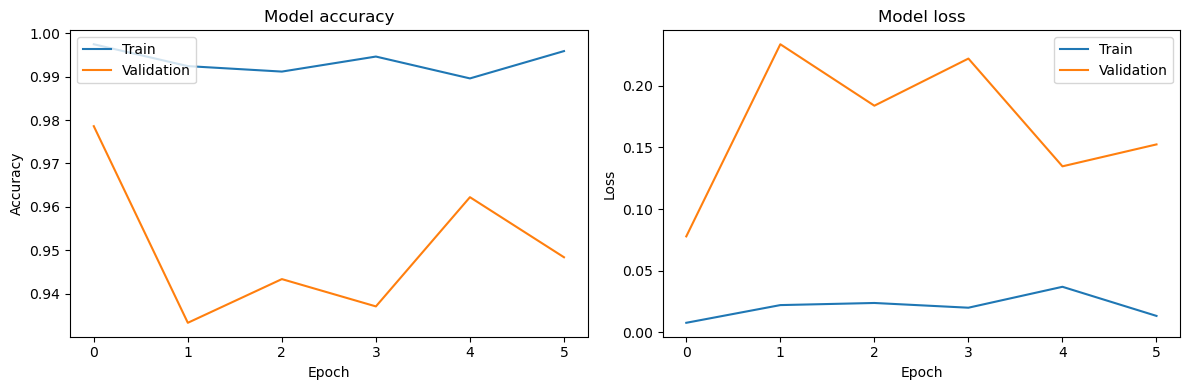

In [33]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()


In [39]:
import numpy as np

# Reduce batch size for predictions
batch_size = 16  # Reduced batch size
num_samples = test_data.shape[0]
num_batches = (num_samples + batch_size - 1) // batch_size

y_pred_prob_tl = []

for i in range(num_batches):
    start = i * batch_size
    end = min((i + 1) * batch_size, num_samples)
    batch_data = test_data[start:end]
    batch_pred = model.predict(batch_data)
    y_pred_prob_tl.append(batch_pred)

y_pred_prob_tl = np.concatenate(y_pred_prob_tl)




1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 823ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 826ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 878ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 878ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [40]:
from sklearn.metrics import matthews_corrcoef, f1_score, precision_score, recall_score

# Convert probabilities to class labels
y_pred_class_tl = (y_pred_prob_tl > 0.5).astype(int)
y_true = test_labels

# Compute Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_true, y_pred_class_tl)
print(f'Matthews Correlation Coefficient: {mcc:.4f}')

# Compute F1-score
f1 = f1_score(y_true, y_pred_class_tl)
print(f'F1 Score: {f1:.4f}')

# Compute precision
precision = precision_score(y_true, y_pred_class_tl)
print(f'Precision: {precision:.4f}')

# Compute recall
recall = recall_score(y_true, y_pred_class_tl)
print(f'Recall: {recall:.4f}')


Matthews Correlation Coefficient: 0.9661
F1 Score: 0.9822
Precision: 0.9979
Recall: 0.9671


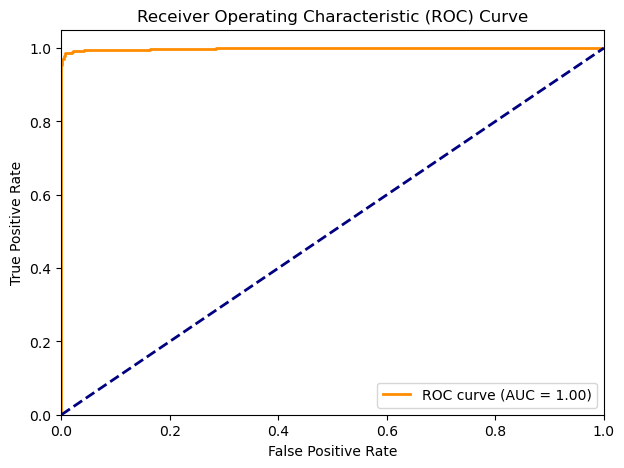

In [45]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob_tl)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



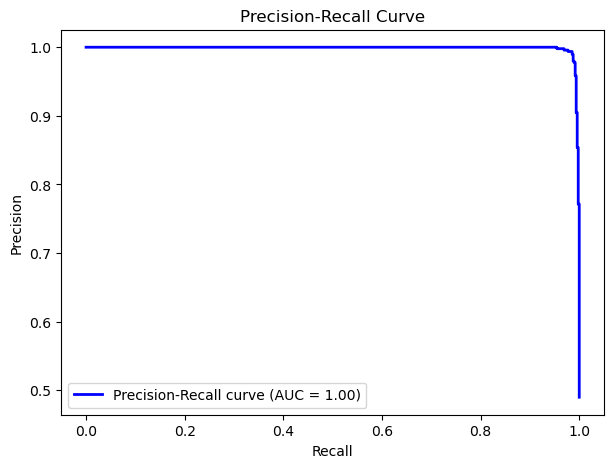

In [46]:
# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred_prob_tl)
pr_auc = auc(recall, precision)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, color='b', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


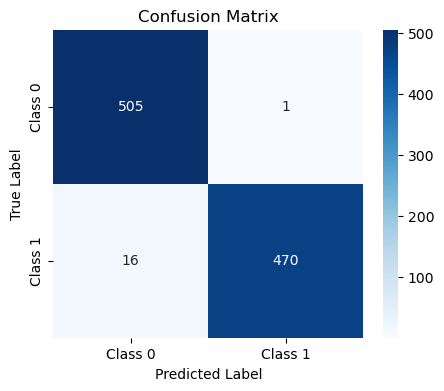

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert probabilities to class labels
y_pred_class_tl = (y_pred_prob_tl > 0.5).astype(int)
y_true = test_labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_class_tl)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



In [48]:
# Compute TP, TN, FP, FN
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
print(f'TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}')

TP: 470, TN: 505, FP: 1, FN: 16


In [49]:
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, matthews_corrcoef, f1_score, precision_score, recall_score, confusion_matrix

# Convert probabilities to class labels
y_pred_class_tl = (y_pred_prob_tl > 0.5).astype(int)
y_true = test_labels

# Compute Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_true, y_pred_class_tl)

# Compute F1-score
f1 = f1_score(y_true, y_pred_class_tl)

# Compute precision
precision = precision_score(y_true, y_pred_class_tl)

# Compute recall
recall = recall_score(y_true, y_pred_class_tl)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_class_tl)

# Compute TP, TN, FP, FN
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

# Compute accuracy
accuracy = accuracy_score(y_true, y_pred_class_tl)

# Compute AUC
auc_score = roc_auc_score(y_true, y_pred_prob_tl)

# Format metrics for display
accuracy = f"{accuracy * 100:.2f}%"
recall = f"{recall * 100:.2f}%"
f1 = f"{f1 * 100:.2f}%"
precision = f"{precision * 100:.2f}%"

# Create a DataFrame to display the metrics
metrics_df = pd.DataFrame({
    'Metric': ['MCC', 'F1-score', 'Precision', 'Recall', 'True Positives', 'True Negatives', 'False Positives', 'False Negatives', 'Accuracy', 'AUC'],
    'Value': [mcc, f1, precision, recall, TP, TN, FP, FN, accuracy, auc_score]
})

metrics_df


,Metric,Value
0,MCC,0.966134
1,F1-score,98.22%
2,Precision,99.79%
3,Recall,96.71%
4,True Positives,470
5,True Negatives,505
6,False Positives,1
7,False Negatives,16
8,Accuracy,98.29%
9,AUC,0.998569


In [50]:
image_path = r'/home/kevin/Downloads/random benign image.png'

In [53]:
# Predict on a new image
def classify_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.expand_dims(image, 0)  # Add batch dimension
    
    prediction = model.predict(image)
    return prediction

print(classify_image(image_path))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[[0.00798535]]


In [54]:
result = classify_image(image_path)
print("Predicted class:", result)

predicted_class = tf.argmax(result, axis=-1).numpy()
print("Predicted class index:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Predicted class: [[0.00798535]]
Predicted class index: [0]


In [55]:
class_labels = ['Benign', 'Malignant']  # Modify according to your classification task
print("Predicted class label:", class_labels[predicted_class[0]])


Predicted class label: Benign
